In [1]:
# Setup
%matplotlib inline
import os
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 20
use_cuda = True

In [3]:
import torch
import torch.utils.data
import torchvision
import torchvision.transforms
import torch.nn as nn
import torch.nn.functional as F

root_dir = os.path.expanduser('~/.pytorch-datasets/')
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [4]:
tf_ds = torchvision.transforms.ToTensor()

batch_size = 512
train_size = batch_size * 10
test_size = batch_size * 2

# Datasets and loaders
ds_train = torchvision.datasets.MNIST(root=root_dir, download=True, train=True, transform=tf_ds)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,train_size)))
ds_test =  torchvision.datasets.MNIST(root=root_dir, download=True, train=False, transform=tf_ds)
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1,
                                       sampler=torch.utils.data.SubsetRandomSampler(range(0,test_size)))

x0, y0 = ds_train[0]
n_features = torch.numel(x0)
n_classes = 10

print(f'x0: {x0.shape}, y0: {y0}')

x0: torch.Size([1, 28, 28]), y0: 5


In [5]:
class MLP(torch.nn.Module):
    NLS = {'relu': torch.nn.ReLU, 'tanh': nn.Tanh, 'sigmoid': nn.Sigmoid, 'softmax': nn.Softmax, 'logsoftmax': nn.LogSoftmax}

    def __init__(self, D_in: int, hidden_dims: list, D_out: int, nonlin='relu'):
        super().__init__()
        
        all_dims = [D_in, *hidden_dims, D_out]
        layers = []
        
        for in_dim, out_dim in zip(all_dims[:-1], all_dims[1:]):
            layers += [
                nn.Linear(in_dim, out_dim, bias=True),
                MLP.NLS[nonlin]()
            ]
        
        self.fc_layers = nn.Sequential(*layers[:-1])
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = torch.reshape(x, (x.shape[0], -1))
        z = self.fc_layers(x)
        y_pred = self.log_softmax(z)
        return y_pred

In [6]:
import torch.optim

# Loss:
# Note: NLLLoss assumes *log*-probabilities (given by our LogSoftmax layer)
loss_fn = nn.NLLLoss()

In [7]:
# Model for training
model = MLP(D_in=n_features, hidden_dims=[32, 32, 32], D_out=n_classes, nonlin='relu').to(device)

# Optimizer over our model's parameters
optimizer = torch.optim.SGD(params=model.parameters(), lr=5e-2, weight_decay=0.01, momentum=0.9)

In [8]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [9]:
def train(adversarial = True, epsilon=0.1):
    num_epochs = 10
    for epoch_idx in range(num_epochs):
        total_loss = 0
        num_adv = 0

        for batch_idx, (X, y) in enumerate(dl_train):
            if adversarial:
                # Set requires_grad attribute of tensor. Important for adversarial training
                X.requires_grad = True

            # Forward pass
            y_pred = model(X)
            init_pred = y_pred[0].max(0, keepdim=True)[1] # get the index of the max log-probability
            
            if adversarial and init_pred.item() == y[0].item(): #then add this as adversarial example
                num_adv += 1
                # Collect datagrad
                loss = loss_fn(y_pred, y)
                optimizer.zero_grad()
                loss.backward()
                data_grad = X.grad.data[0]
                # Call FGSM Attack
                perturbed_data = fgsm_attack(X[0], epsilon, data_grad)
                # add adversarial to data
                X = torch.cat((X,perturbed_data.unsqueeze(dim=0)))
                y = torch.cat((y,y[0].unsqueeze(dim=0)))
                y_pred = model(X)

            # Compute loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # Backward pass
            optimizer.zero_grad() # Zero gradients of all parameters
            loss.backward()       # Run backprop algorithms to calculate gradients

            # Optimization step
            optimizer.step()      # Use gradients to update model parameters
        print(f'Epoch #{epoch_idx+1}: Avg. loss={total_loss/(len(dl_train)+num_adv)}')
        
train(False)

Epoch #1: Avg. loss=2.303045463562012
Epoch #2: Avg. loss=2.2900847673416136
Epoch #3: Avg. loss=2.270097017288208
Epoch #4: Avg. loss=2.2248563528060914
Epoch #5: Avg. loss=2.0669830203056336
Epoch #6: Avg. loss=1.6081655979156495
Epoch #7: Avg. loss=1.0657500445842742
Epoch #8: Avg. loss=0.8104629695415497
Epoch #9: Avg. loss=0.6624449610710144
Epoch #10: Avg. loss=0.5364545941352844


In [10]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [11]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, dl_test, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 832 / 1024 = 0.8125
Epsilon: 0.05	Test Accuracy = 555 / 1024 = 0.5419921875
Epsilon: 0.1	Test Accuracy = 209 / 1024 = 0.2041015625
Epsilon: 0.15	Test Accuracy = 54 / 1024 = 0.052734375
Epsilon: 0.2	Test Accuracy = 13 / 1024 = 0.0126953125
Epsilon: 0.25	Test Accuracy = 0 / 1024 = 0.0
Epsilon: 0.3	Test Accuracy = 0 / 1024 = 0.0


Results
-------

Accuracy vs Epsilon
~~~~~~~~~~~~~~~~~~~


The first result is the accuracy versus epsilon plot. As alluded to
earlier, as epsilon increases we expect the test accuracy to decrease.
This is because larger epsilons mean we take a larger step in the
direction that will maximize the loss. Notice the trend in the curve is
not linear even though the $\epsilon$ values are linearly spaced. For
example, the accuracy at $\epsilon=0.05$ is only about 4% lower
than $\epsilon=0$, but the accuracy at $\epsilon=0.2$ is 25%
lower than $\epsilon=0.15$. Also, notice the accuracy of the model
hits random accuracy for a 10-class classifier between
$\epsilon=0.25$ and $\epsilon=0.3$.

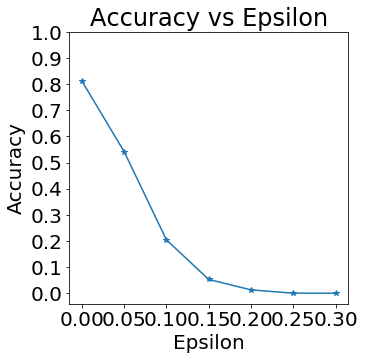

In [12]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

**Sample Adversarial Examples**


Remember the idea of no free lunch? In this case, as epsilon increases
the test accuracy decreases **BUT** the perturbations become more easily
perceptible. In reality, there is a tradeoff between accuracy
degredation and perceptibility that an attacker must consider. Here, we
show some examples of successful adversarial examples at each epsilon
value. Each row of the plot shows a different epsilon value. The first
row is the $\epsilon=0$ examples which represent the original
“clean” images with no perturbation. The title of each image shows the
“original classification -> adversarial classification.” Notice, the
perturbations start to become evident at $\epsilon=0.15$ and are
quite evident at $\epsilon=0.3$. However, in all cases humans are
still capable of identifying the correct class despite the added noise.

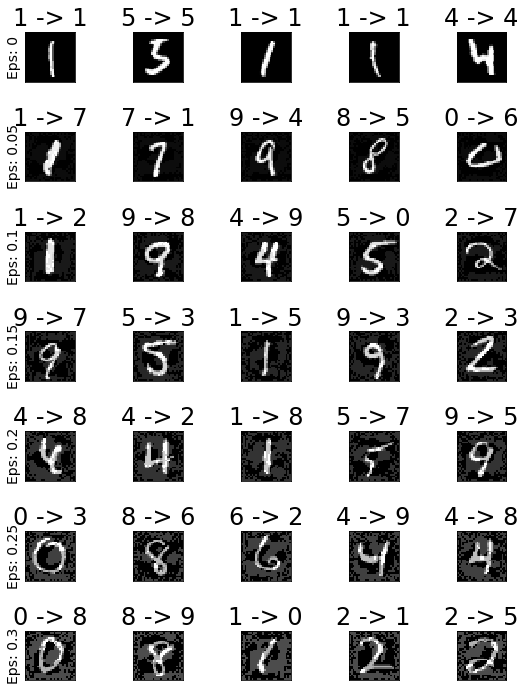

In [13]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

Where to go next?
-----------------

Hopefully this tutorial gives some insight into the topic of adversarial
machine learning. There are many potential directions to go from here.
This attack represents the very beginning of adversarial attack research
and since there have been many subsequent ideas for how to attack and
defend ML models from an adversary. In fact, at NIPS 2017 there was an
adversarial attack and defense competition and many of the methods used
in the competition are described in this paper: `Adversarial Attacks and
Defences Competition <https://arxiv.org/pdf/1804.00097.pdf>`__. The work
on defense also leads into the idea of making machine learning models
more *robust* in general, to both naturally perturbed and adversarially
crafted inputs.

Another direction to go is adversarial attacks and defense in different
domains. Adversarial research is not limited to the image domain, check
out `this <https://arxiv.org/pdf/1801.01944.pdf>`__ attack on
speech-to-text models. But perhaps the best way to learn more about
adversarial machine learning is to get your hands dirty. Try to
implement a different attack from the NIPS 2017 competition, and see how
it differs from FGSM. Then, try to defend the model from your own
attacks.


